In [2]:
import pandas as pd
import numpy as np
import pandas_datareader.stooq
from scipy.stats import chi2
from scipy.stats import f
import statsmodels.api as sm
import random 
import math 
import statistics 
import datetime
import matplotlib.pyplot as plt

Dane pobrane za okres: **20.03.2020 - 16.05.2022** (pandemia COVID)

# Wybrane spółki/ indeksy

In [13]:

tickers =   [
                'CMR',
                'DAT',
                'LVC',
                'SGN',
                'WIG20',
                'WIG'
            ]     
            


## Zakres czasu danych

In [15]:
d = {}

for tick in tickers:
    d[tick] = pd.DataFrame(pandas_datareader.stooq.StooqDailyReader( tick + '.PL', start = '20/03/20', end = '16/05/22').read()).sort_index()
    d[tick]['r'] = np.log(d[tick].Close) - np.log(d[tick].Close.shift(1))

# 1. Test autokorelacji

## Autokorelacja

$$ 
\large{
    \hat{\rho}(k) = \frac {\sum_{t=1}^{T-k} (r_t - \bar{r}_T) (r_{k+t} - \bar{r}_T)} { \sum_{t=1}^T (r_t - \hat{r}_T)^2 } 
    } 
$$

Przy założeniu, że przyrosty są niezależnymi zmiennymi losowymi o jednakowych rozkładach, można wykazać, że 
$ \sqrt{T}\hat{\rho}(k)$ ma rozkład asymptotyczny $N(0,1)$. 
Przy poziomie istotności 0,05 możemy odrzucić hipotezę błądzenia losowego jeżeli statystyka testowa przekroczy co do wartości bezwzględnej **1,96**.

## Statystyka testowa

$$ 
\large{
    \sqrt{T}\hat{\rho}(k)
    } 
$$

In [16]:
def autokorelacja(ticker, k):   
    
    acf = d[ticker]['r'].autocorr(lag=k)
    T = len(d[ticker]['r'])
    stat = math.sqrt(T)*acf
    
    
    return round(acf,4), round(stat,4)

In [17]:
k_values = [1, 2, 5, 10, 20, 50, 100]
acf = []
stats = []

for ticker in tickers:
    for k in k_values:
        
        acf.append({
            'Spółka': ticker,
            'Miara': 'autokorelacja',
            'k': k,
            'Wartość': autokorelacja(ticker, k)[0]
            
        })
        
        stats.append({
            'Spółka': ticker,
            'Miara': 'statystyka testowa',
            'k': k,
            'Wartość': autokorelacja(ticker, k)[1]
            
        })
                     
acf = pd.DataFrame(acf)
stats = pd.DataFrame(stats)
autokor = pd.concat([acf, stats])

In [18]:
autokor = autokor.pivot(index=['Spółka','Miara'], columns='k', values=['Wartość'])

In [19]:
def highlight_n(val):
    if abs(val) > 1.96:
        #color = 'red'
        return "color: red"

In [20]:
autokor = autokor.style.applymap(highlight_n, subset=pd.IndexSlice[:,pd.IndexSlice['statystyka testowa'],:])

In [21]:
autokor

# 2. Statystyka Boxa-Ljunga

$$ 
\large{
    Q_m = T\times(T+2)\sum_{k=1}^{m} \frac {\hat{\rho}(k)^2} {(T-1)}
    } 
$$

Wychodząc z wniosku, że dla zwykłego błądzenia losowego wszystkie autokorelacje są równe zeru, statystyka $Q_m$ ma asymptotyczny rozkład $\chi_m^2$. Gdy wartość empiryczna statystyki $Q_m$ przekroczy wartość teoretyczną przy danym poziomie istotności i stopniach swobody, możemy odrzucić hipotezę błądzenia losowego. 

In [22]:
def box_ljung(ticker, m):  
    
    df = d[ticker].dropna() 
    
    bxlj = sm.stats.diagnostic.acorr_ljungbox(df['r'], lags=[m], return_df = True).iloc[0,0]
    
    
    return round(bxlj,4)


In [23]:
m_values = [10,20,50,100]
bx_lj = []

for m in m_values:
    for ticker in tickers:
        bx_lj.append({
            'Spółka': ticker,
            'Stopień testu': m,
            'Wartość': box_ljung(ticker, m)
            
        })
    bx_lj.append({'Spółka': 'Wartość krytyczna',
                'Stopień testu': m,
               'Wartość': round(chi2.ppf(1-.05, df=m),4) })
        
bx_lj = pd.DataFrame(bx_lj)

In [24]:
bx_lj = bx_lj.pivot(index=['Spółka'], columns='Stopień testu', values=['Wartość']).sort_index(ascending=False)


In [26]:
def highlight_bxlj(df, color = "red"):
    attr = 'color: {}'.format(color)
    df_bool = pd.DataFrame(df.apply(lambda x: ["red" if v > x.iloc[0] else "" for v in x], axis = 0).apply(pd.Series),
                      index=df.index)
    df_bool.columns =df.columns
    return pd.DataFrame(np.where(df_bool, attr, ""),
                       index= df.index, columns=df.columns)

bx_lj = bx_lj.style.apply(highlight_bxlj, axis=None)


In [28]:
bx_lj

# 3. Test serii

Hipotezę zerową (dane generowane przez biały szum) odrzucamy jeśli $K$ jest większe co do wartości bezwzględnej **1,96** przy poziomie istotności 0,05. Jeśli $K < 0$, co oznacza liczbę serii mniejszą niż oczekiwana, możemy uznać, że w danych przeważają trendy. Dodatnia wartość $K$ świadczy o obecności procesu powracania do średniej.

In [29]:
def test_serii(ticker):
    
    l = d[ticker]['r'].apply(lambda x: 1 if x>0 else 0)
    l = l.to_numpy()
    
    ts = sm.stats.runstest_1samp(l, cutoff='mean', correction=True)[0] #statystyka Z
    
    return round(ts,4)
    

In [30]:
ts = []

for ticker in tickers:
    
    ts.append({
            'Spółka': ticker,
            'Wartość K': test_serii(ticker)
            
        })
ts = pd.DataFrame(ts, columns=['Spółka','Wartość K']).set_index('Spółka')


In [31]:
ts = ts.style.applymap(highlight_n)
#ts.to_excel("test_serii.xlsx")
ts

,Wartość K
Spółka,
CMR,1.445600
DAT,2.711800
LVC,1.921000
SGN,1.157000
WIG20,0.173600
WIG,-0.419500


# 4. Testy wariancji 

## VR(2)

Można wykazać, że statystyka testowa
$ \frac {V\hat{R}(2)-1} {\sqrt{2}} $ ma rozkład asymptotyczny $N(0,1)$. 
Przy poziomie istotności 0,05 możemy odrzucić hipotezę błądzenia losowego jeżeli statystyka testowa przekroczy co do wartości bezwzględnej **1,96**.

In [32]:
def ilorazy_wariancji(ticker):
    df = d[ticker]
    r = df['r']
    r2 = np.log(df.Close[0::2]) - np.log(df.Close[0::2].shift(1))
    r2.dropna(inplace = True)
    sr_rk = np.mean(r)
    T = len (df['r'])
    r.dropna(inplace=True)
    VAR_Rt =  1/T * sum((r-sr_rk)**2)
    VAR_R2 = 1/(T/2) * sum((r2-2*sr_rk)**2)
    VR2 = VAR_R2 / (2*VAR_Rt)
    
    statystyka_testowa = ((VR2-1)/np.sqrt(2) * np.sqrt(T))
    
    return round(VR2,4), round(statystyka_testowa,4)
    

In [33]:
iw = []

for ticker in tickers:
    
    iw.append({
            'Spółka': ticker,
            'VR': ilorazy_wariancji(ticker)[0],
            'Statystyka testowa': ilorazy_wariancji(ticker)[1]
            
        })
iw = pd.DataFrame(iw, columns=['Spółka','VR', 'Statystyka testowa']).set_index('Spółka')


In [34]:
iw = iw.style.applymap(highlight_n, subset=pd.IndexSlice[:, ['Statystyka testowa']])
#iw.to_excel("vr2.xlsx")
iw

,VR,Statystyka testowa
Spółka,,
CMR,0.762000,-3.910600
DAT,0.876100,-2.035500
LVC,0.838200,-2.658700
SGN,0.905100,-1.559400
WIG20,0.789200,-3.464500
WIG,0.807200,-3.168600


## VR(q)

Można wykazać, że statystyka testowa
$ \psi(q) $ również ma rozkład asymptotyczny $N(0,1)$. 
Przy poziomie istotności 0,05 możemy odrzucić hipotezę błądzenia losowego jeżeli statystyka testowa przekroczy co do wartości bezwzględnej **1,96**.

In [35]:
def ilorazy_wariancji_q(ticker, q):
    df = d[ticker]
    r = df['r']
    rq = np.log(df.Close) - np.log(df.Close.shift(q))    
    rq.dropna(inplace = True)
    sr_rk = np.mean(r)
    T = len(df['r'])
    n=T/q
    r.dropna(inplace=True)
    
    m=q*(T-q-1)*(1-q/T)
    
    VAR_Rt =  1/T * sum((r-sr_rk)**2)
    VAR_Rq = q/m * sum((rq-q*sr_rk)**2)
    VRq = VAR_Rq / (q*VAR_Rt)
    
    statystyka_testowa = (math.sqrt(T)*(VRq-1)) /(math.sqrt((2*(2*q-1)*(q-1)) / (3*q)))
    
    return VRq, round(statystyka_testowa,4)
    

In [36]:
q_values = [2,4,8,16]
vrq = []
st = []

for q in q_values:
    for ticker in tickers:
        vrq.append({
            'Spółka': ticker,
            'Miara': 'VR(q)',
            'Opóźnienie q': q,
            'Wartość': ilorazy_wariancji_q(ticker, q)[0]            
        })
        
        st.append({
            'Spółka': ticker,
            'Miara': 'Statystyka testowa',
            'Opóźnienie q': q,
            'Wartość': ilorazy_wariancji_q(ticker, q)[1]
            
        })
        
vrq = pd.DataFrame(vrq)
st = pd.DataFrame(st)
iwq = pd.concat([vrq, st])

In [37]:
iwq = iwq.pivot(index=['Spółka','Miara'], columns='Opóźnienie q', values=['Wartość']).unstack()
iwq.columns = iwq.columns.droplevel()

In [38]:
iwq = iwq.style.applymap(highlight_n, subset=pd.IndexSlice[:, iwq.columns.get_level_values(1)=='Statystyka testowa'])

In [39]:
#iwq.to_excel("vrq.xlsx")
iwq

# 5. Efekty kalendarzowe

Jeśli hipoteza zerowa (ceny/stopy zwrotu są niezależne od czasu, co oznacza, że nie powinny zależeć również np. od dni tygodnia, miesiąca roku itd.) jest prawdziwa, to wariancja międzygrupowa ma rozkład Fischera. Statystyka F to iloraz wariancji między- i wewnątrzgrupowej. Tak obliczoną wartość porównujemy z wartością krytyczną z rozkładu $F$ o $(k-1, T-1)$ stopniach swobody.  Jeżeli wartość krytyczna zostanie przekroczona, to odrzucamy hipotezę o równych średnich, co oznacza występowanie efektu kalendarzowego. 

## Dni

In [40]:
def efekty_kalendarzowe_dni(ticker):
    
    df = d[ticker]      
    df = df.reset_index()
   
    df['day_no'] = df['Date'].apply(lambda x: x.weekday())     
    dni = {0:'Poniedziałek', 1:'Wtorek', 2:'Środa', 3:'Czwartek', 4:'Piątek', 5:'Sobota', 6:'Niedziela'}
    df['Dzień'] = df['day_no'].map(dni)
    
    srednie = df.groupby(by='Dzień').mean()[['r']].T
    srednie['Spółka'] = ticker
    
    wyniki = []
    suma_m2n = 0
    roznice = 0

    for day in df['Dzień'].unique():
        m = df[df['Dzień']==day].groupby(by='Dzień').sum()['r'][0]    
        r2 = df[df['Dzień']==day]['r'].pow(2).sum()
        n = len(df[df['Dzień']==day])
        m2n = m**2 / n    
        suma_m2n += m2n    
        roznice += (r2-m2n)
    
    r_all = df['r'].sum()
    n_all = len(df['r'])
    
    var_miedzygrupowa = suma_m2n - (r_all/n_all)
    var_wewnatrzgrupowa = roznice
    statystyka_f = var_miedzygrupowa/var_wewnatrzgrupowa
    
    srednie['Statystyka F'] = statystyka_f
    srednie['Wartość krytyczna F'] = f.ppf(q=1-.05, dfn=4, dfd=(n_all-1))
    srednie = srednie.set_index('Spółka')    
    
    
    return srednie    

In [41]:
ek_d = []

for ticker in tickers:
    data = efekty_kalendarzowe_dni(ticker)
    ek_d.append(data)

ek_d = pd.concat(ek_d)
ek_d = ek_d[['Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Statystyka F', 'Wartość krytyczna F']]


In [42]:
ek_d = ek_d.style.apply(lambda x: ["background: red" if x[0] > x.iloc[1] else "" for v in x], axis = 1, subset=['Statystyka F', 'Wartość krytyczna F'])

In [43]:
#ek_d.to_excel("efekty_kal_dni.xlsx")

In [44]:
ek_d

Dzień,Poniedziałek,Wtorek,Środa,Czwartek,Piątek,Statystyka F,Wartość krytyczna F
Spółka,,,,,,,
CMR,0.001647,0.001717,-0.000525,-0.003040,0.000360,0.005800,2.388471
DAT,0.000319,0.003191,0.001058,0.002047,0.007491,0.004446,2.388471
LVC,0.001648,-0.003538,0.004319,0.006122,-0.000642,0.014995,2.388471
SGN,0.005619,0.005839,-0.003402,-0.000050,0.003389,0.014691,2.388471
WIG20,0.001107,0.002167,0.000531,-0.001427,-0.000947,0.005071,2.388471
WIG,0.001501,0.002104,0.000760,-0.001222,-0.000529,0.004074,2.388471


## Miesiące

In [45]:
def efekty_kalendarzowe_miesiace(ticker):
    
    df = d[ticker]      
    df = df.reset_index()
           
    df['month_no'] = df['Date'].apply(lambda x: x.month)
    miesiace = {1:'Styczeń', 2:'Luty', 3:'Marzec', 4:'Kwiecień', 5:'Maj', 6:'Czerwiec', 7:'Lipiec', 8:'Sierpień',
                9:'Wrzesień', 10:'Październik', 11:'Listopad', 12:'Grudzień'}
    df['Miesiąc'] = df['month_no'].map(miesiace)
    
    
    srednie = df.groupby(by='Miesiąc').mean()[['r']].T
    srednie['Spółka'] = ticker
    
    wyniki = []
    suma_m2n = 0
    roznice = 0

    for month in df['Miesiąc'].unique():
        m = df[df['Miesiąc']==month].groupby(by='Miesiąc').sum()['r'][0]    
        r2 = df[df['Miesiąc']==month]['r'].pow(2).sum()
        n = len(df[df['Miesiąc']==month])
        m2n = m**2 / n    
        suma_m2n += m2n    
        roznice += (r2-m2n)
    
    r_all = df['r'].sum()
    n_all = len(df['r'])
    
    var_miedzygrupowa = suma_m2n - (r_all/n_all)
    var_wewnatrzgrupowa = roznice
    statystyka_f = var_miedzygrupowa/var_wewnatrzgrupowa
    
    srednie['Statystyka F'] = statystyka_f
    srednie['Wartość krytyczna F'] = f.ppf(q=1-.05, dfn=4, dfd=(n_all-1))
    srednie = srednie.set_index('Spółka')    
    
    
    return srednie    

In [46]:
ek_m = []

for ticker in tickers:
    data = efekty_kalendarzowe_miesiace(ticker)
    ek_m.append(data)

ek_m = pd.concat(ek_m)
ek_m = ek_m[['Styczeń', 'Luty', 'Marzec', 'Kwiecień', 'Maj','Czerwiec', 'Lipiec','Sierpień', 'Wrzesień', 'Październik', 'Listopad', 'Grudzień','Statystyka F', 'Wartość krytyczna F']]



In [47]:
ek_m = ek_m.style.apply(lambda x: ["background: red" if x[0] > x.iloc[1] else "" for v in x], axis = 1, subset=['Statystyka F', 'Wartość krytyczna F'])



In [48]:
#ek_m.to_excel("efekty_kal_mies.xlsx")
ek_m

Miesiąc,Styczeń,Luty,Marzec,Kwiecień,Maj,Czerwiec,Lipiec,Sierpień,Wrzesień,Październik,Listopad,Grudzień,Statystyka F,Wartość krytyczna F
Spółka,,,,,,,,,,,,,,
CMR,0.000404,-0.001465,0.005910,0.000873,0.000372,0.001952,0.002982,-0.001122,-0.003022,-0.003217,-0.002039,-0.003156,0.014481,2.388471
DAT,-0.007132,-0.001995,0.002501,0.008787,0.001167,0.015256,0.009372,-0.000925,0.003953,-0.002061,-0.000336,0.001342,0.018207,2.388471
LVC,-0.000307,-0.000281,0.000987,0.004464,-0.000669,0.004452,0.006068,-0.001760,-0.001272,0.004305,0.000230,0.001482,0.007888,2.388471
SGN,0.000364,0.003862,0.005414,0.000762,0.000768,0.010761,0.000620,0.001953,0.001321,-0.001961,0.001717,0.002014,0.010887,2.388471
WIG20,-0.001126,-0.003022,0.001833,-0.000039,0.001653,0.000335,0.000458,0.001579,-0.001693,-0.001903,0.002415,0.002763,0.010211,2.388471
WIG,-0.000726,-0.002447,0.001705,0.000538,0.001694,0.000624,0.000922,0.001634,-0.001188,-0.001597,0.002384,0.002479,0.007870,2.388471


# Zapis do Excela

In [49]:
with pd.ExcelWriter('testy_covid.xlsx') as writer:
    autokor.to_excel(writer, sheet_name='Autokorelacja')
    bx_lj.to_excel(writer, sheet_name='Box Ljung')
    ts.to_excel(writer, sheet_name='Test serii')
    iw.to_excel(writer, sheet_name='Ilorazy wariancji (2)')
    iwq.to_excel(writer, sheet_name='Ilorazy wariancji (q)')
    ek_d.to_excel(writer, sheet_name='Efekty kalendarzowe (dni)')
    ek_m.to_excel(writer, sheet_name='Efekty kalendarzowe (miesiące)')
    

# 6. Średnie ruchome

In [50]:
def srednia_ruchoma_prosta(ticker, win):
    df = d[ticker] 
    zamkniecie = df['Close']
    ema = zamkniecie.rolling(window=win).mean()
    
    plt.figure(figsize=(12, 8), dpi=80)
    plt.plot(zamkniecie, label="Zamknięcie dnia")
    plt.plot(ema, label="Średnia ruchoma prosta")      
    plt.legend(loc="upper left")
    plt.title("Średnia ruchoma prosta (" + str(win) + ") dla " + ticker)
    plt.show()

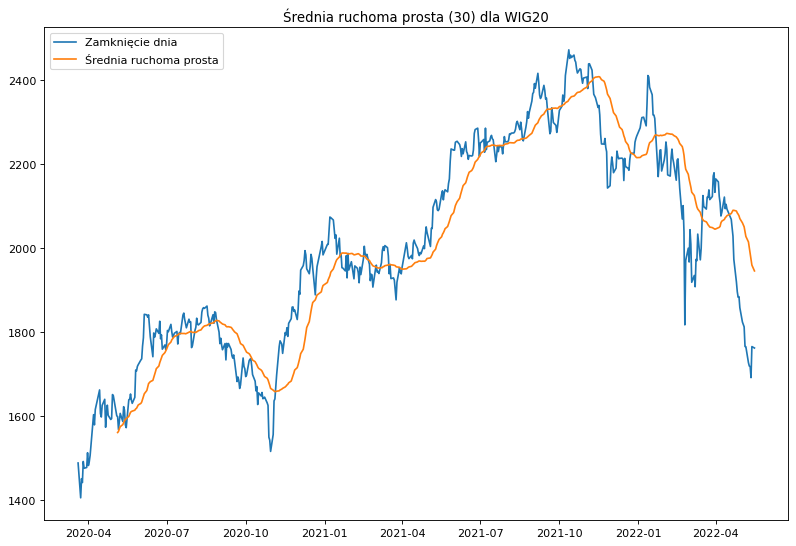

In [52]:
srednia_ruchoma_prosta('WIG20', 30)

In [53]:
def srednia_ruchoma_wykladnicza(ticker, win):    
    df = d[ticker] 
    zamkniecie = df['Close']
    ema = zamkniecie.ewm(span=win).mean()
    
    plt.figure(figsize=(12, 8), dpi=80)
    plt.plot(zamkniecie, label="Zamknięcie dnia")
    plt.plot(ema, label="Średnia ruchoma wykładnicza")      
    plt.legend(loc="upper left")
    plt.title("Średnia ruchoma wykładnicza (" + str(win) + ") dla " + ticker)
    plt.show()

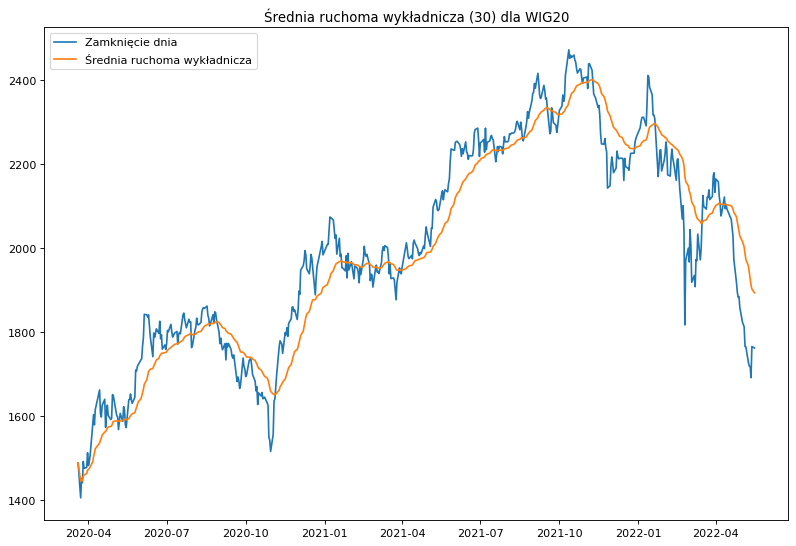

In [54]:
srednia_ruchoma_wykladnicza('WIG20', 30)

In [55]:
def s_prosta(ticker, win):
    df = d[ticker] 
    zamkniecie = df['Close']
    ema = zamkniecie.rolling(window=win).mean()
    
    srednie = pd.DataFrame(data=ema)
    srednie.columns = [ticker + " Średnia ruchoma prosta " + str(win) + " dni"]
    
    return srednie

In [56]:
def s_wykladnicza(ticker, win):
    df = d[ticker] 
    zamkniecie = df['Close']
    ema = zamkniecie.ewm(span=win, min_periods=0,adjust=False,ignore_na=False).mean()
    
    
    srednie = pd.DataFrame(data=ema)
    srednie.columns = [ticker + " Średnia ruchoma wykładnicza " + str(win) + " dni"]
    
    return srednie

In [57]:
srednie_proste = []
for ticker in tickers:
    data = s_prosta(ticker,30)
    srednie_proste.append(data)

srednie_proste = pd.concat(srednie_proste, axis=1 )
srednie_proste.to_excel('srednie_proste.xlsx')

In [58]:
srednie_wykladnicze = []
for ticker in tickers:
    data = s_wykladnicza(ticker,30)
    srednie_wykladnicze.append(data)

srednie_wykladnicze = pd.concat(srednie_wykladnicze, axis=1 )
srednie_wykladnicze.to_excel('srednie_wykladnicze.xlsx')

In [59]:
srednie_proste

,CMR Średnia ruchoma prosta 30 dni,DAT Średnia ruchoma prosta 30 dni,LVC Średnia ruchoma prosta 30 dni,SGN Średnia ruchoma prosta 30 dni,WIG20 Średnia ruchoma prosta 30 dni,WIG Średnia ruchoma prosta 30 dni
Date,,,,,,
2020-03-20,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-23,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-24,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-25,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-26,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2022-05-10,176.381367,178.643333,92.840780,11.429667,2000.861667,61450.258333
2022-05-11,175.652300,177.510000,92.726170,11.349333,1987.611333,61099.577333
2022-05-12,175.001333,176.465333,92.697517,11.276000,1973.228000,60715.999000


In [60]:
srednie_wykladnicze

,CMR Średnia ruchoma wykładnicza 30 dni,DAT Średnia ruchoma wykładnicza 30 dni,LVC Średnia ruchoma wykładnicza 30 dni,SGN Średnia ruchoma wykładnicza 30 dni,WIG20 Średnia ruchoma wykładnicza 30 dni,WIG Średnia ruchoma wykładnicza 30 dni
Date,,,,,,
2020-03-20,164.199000,37.200000,38.660000,2.900000,1488.420000,41153.200000
2020-03-23,164.755839,36.980645,38.500594,2.884516,1483.067097,41027.660000
2020-03-24,165.153333,36.956087,38.394910,2.873902,1480.999542,40979.159355
2020-03-25,165.710989,36.894404,38.272813,2.860747,1478.472475,40925.296171
2020-03-26,166.046861,36.843152,38.193470,2.850376,1479.345864,40943.211256
...,...,...,...,...,...,...
2022-05-10,172.169446,175.085442,91.772718,10.907546,1941.867010,59880.199169
2022-05-11,171.745933,174.499285,91.489987,10.812866,1927.428493,59494.360513
2022-05-12,171.248905,173.567718,91.379549,10.734616,1912.215042,59080.181125


# *****

# Inne

In [61]:
df = d['WIG20'] 

Text(0.5, 1.0, 'Close')

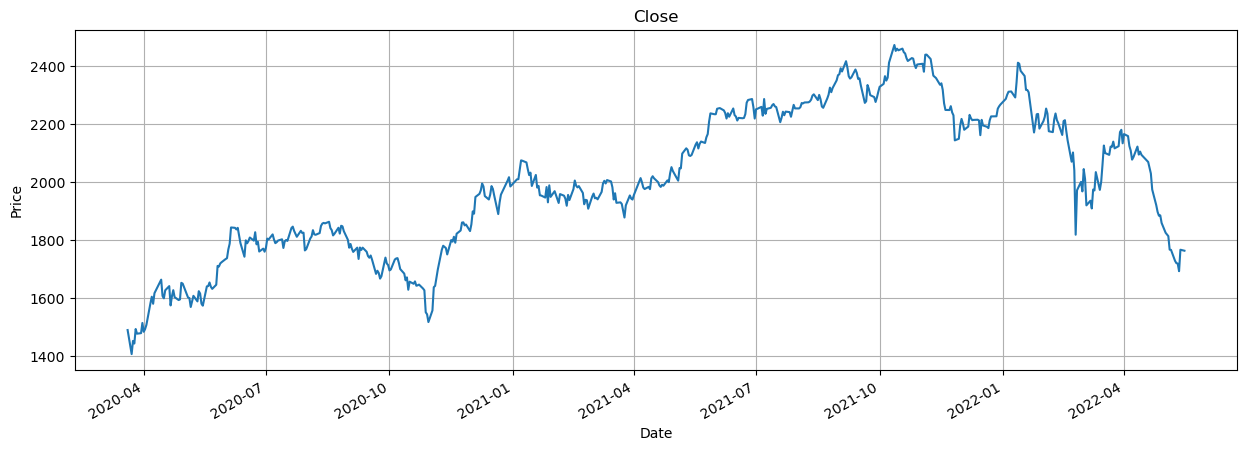

In [62]:
plt.figure(figsize=(15,5))
df['Close'].plot(grid=True)
plt.ylabel('Price')
plt.title('Close')

In [63]:
df['delta'] = np.append(np.array([0]),
                        np.diff(df['Close'].values))

sp=np.fft.fft(df['delta'].values)

df['theta']=np.arctan(sp.imag/sp.real)

numValues = len(df)
numValuesHalf = numValues/2

df['amplitude']=np.sqrt(sp.real**2 + sp.imag**2)/numValuesHalf
df['freq'] = np.fft.fftfreq(sp.size, d=1)

df.head()


,Open,High,Low,Close,Volume,r,delta,theta,amplitude,freq
Date,,,,,,,,,,
2020-03-20,1502.14,1547.74,1476.65,1488.42,109516157,NaN,0.00,0.000000,1.014074,0.000000
2020-03-23,1461.22,1463.93,1400.71,1405.45,43978401,-0.057358,-82.97,0.536738,2.760885,0.001852
2020-03-24,1449.34,1473.02,1424.14,1451.02,37402637,0.031909,45.57,-1.262690,1.872138,0.003704
2020-03-25,1487.75,1505.79,1413.22,1441.83,47382329,-0.006354,-9.19,-0.937039,1.343266,0.005556
2020-03-26,1431.53,1492.87,1410.91,1492.01,36791461,0.034211,50.18,1.277223,3.065326,0.007407


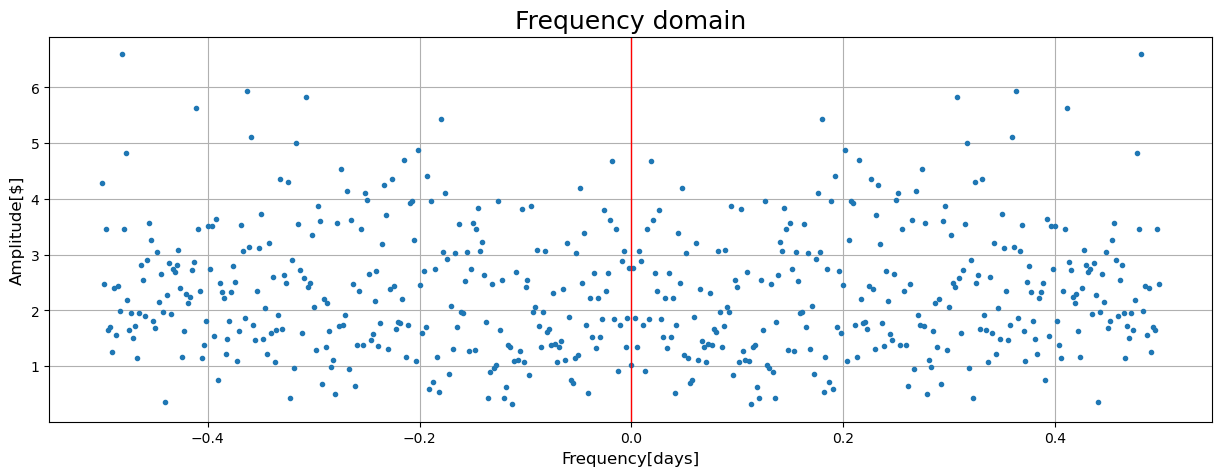

In [64]:
plt.figure(figsize=(15,5))
plt.plot(df['freq'],df['amplitude'].values,'.')
plt.axvline(x=0,ymin=0,ymax=1,linewidth=1,color='r')
plt.ylabel('Amplitude[$]', fontsize=12)
plt.xlabel('Frequency[days]', fontsize=12)
plt.title('Frequency domain', fontsize=18)
plt.grid()

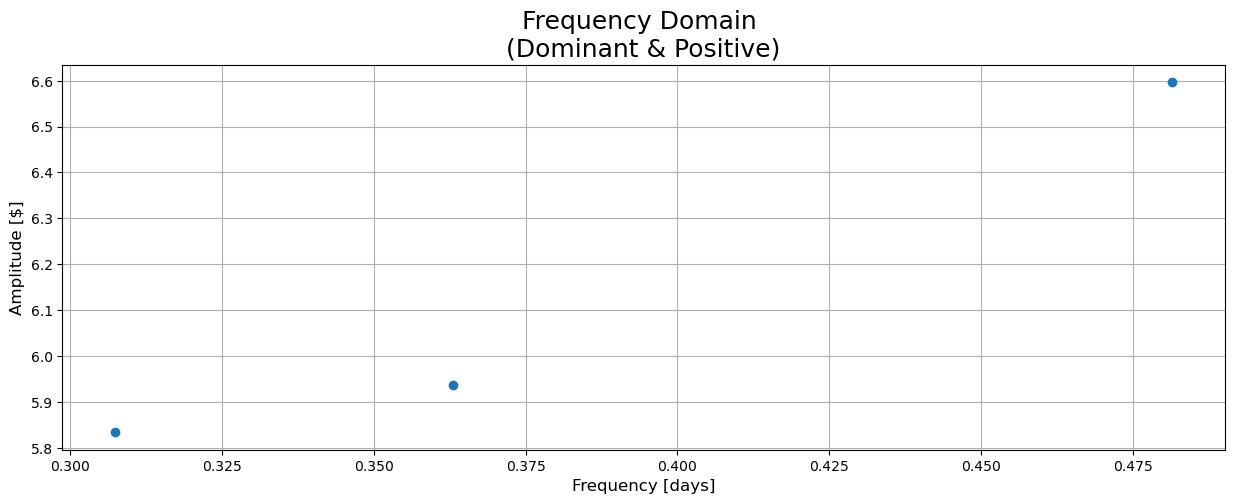

In [65]:
meanAmp = df['amplitude'].mean()
stdAmp = df['amplitude'].std()
dominantAmpCheck = df['amplitude'] > (3*stdAmp + meanAmp) 
positiveFreqCheck = df['freq'] > 0
dominantAmp = df[dominantAmpCheck & positiveFreqCheck]['amplitude']
dominantFreq = df[dominantAmpCheck & positiveFreqCheck]['freq']
dominantTheta = df[dominantAmpCheck & positiveFreqCheck]['theta']

plt.figure(figsize=(15,5))
plt.plot(dominantFreq, dominantAmp, 'o')
plt.ylabel('Amplitude [$]', fontsize=12)
plt.xlabel('Frequency [days]', fontsize=12)
plt.title('Frequency Domain \n(Dominant & Positive)', fontsize=18)
plt.grid();